# Half-space Monte Carlo AVO modelling

This functionality replaces the Blocky Ops AVO modelling in RokDoc

Import the necessary python scripts

In [1]:
import os
import utils.half_space_avo_monte_carlo as havo
import utils.io as uio

Give the name of the .xlsx file containing the statistics of the different intervals (**This is the output from the notebook** *run calculation of Sums and Averages.ipynb*)
Result plots are saved in the same folder as where the .xlsx file is situated
If the .xlsx file is situated elsewhere, just make sure to give the full path to it, using "forward slashes"

In [2]:
# filename = 'X:/A_Folder/Somehwere/Else/RokDoc_SumsAverages_from_python.xlsx'
filename = 'results_folder/RokDoc_SumsAverages_from_python.xlsx'

Now define the intervals that make up the top(s) and base(s) of the half-space model(s)
It is a complicated list of list of lists, with the inner most list contains 
 - ['top_name', 'base_name', 'color']
 
which define one half-space model, and the color of how it is plottet.
The names must exist in the above given .xlsx file.
For name of python plot colors see https://matplotlib.org/2.0.2/api/colors_api.html

The middle layer of lists is used if you want to combine several half-space models in the same plot
And the outermost layer of list can be used to run several monte-carlo simulations at once. 
The list of suffixes are used in the naming of the plots


In [3]:
many_interfaces = [
        [['Shale G_my_test', 'Sand H_my_test', 'b'],
         ['Shale G_my_test', 'Sand F_my_test', 'r']]            
    ]
suffixes = [
        'test',
]

Read in the Sums & Averages file

In [4]:
sums = uio.read_sums_and_averages(filename)

Class I: 25% 
Class IIp: 37% 
Class II: 10% 
Class III: 12% 
Class IV: 16%
Rest:  0%
Class I: 19% 
Class IIp: 37% 
Class II: 11% 
Class III: 17% 
Class IV: 17%
Rest:  0%


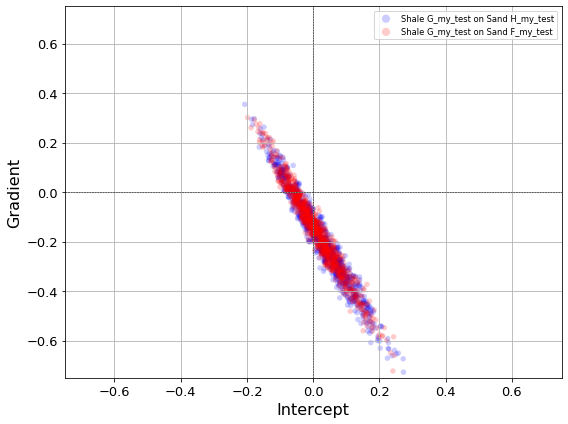

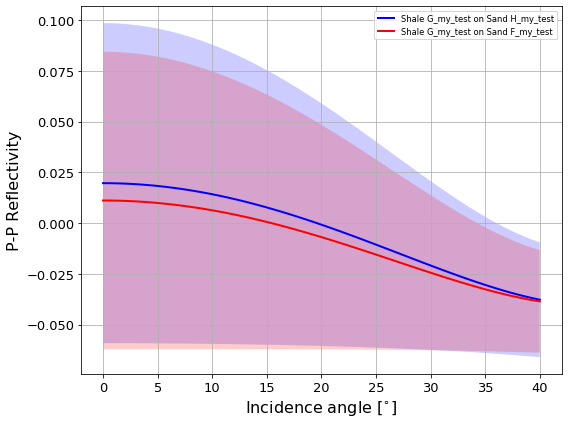

In [5]:
for i, interfaces in enumerate(many_interfaces):
    havo.plot_multi_interfaces(
            sums, 
            interfaces, 
            os.path.split(filename)[0],
            suffixes[i])
        
